In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from Utils.preprocessing import EcgDataset, ToTensor

transform = transforms.Compose([
    ToTensor(),
    transforms.Resize([64, 64])
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = EcgDataset(
    root_dir="Data/training_data/dataset",
    transform=transform
)

train_data, val_data = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=64,
    shuffle=True
)

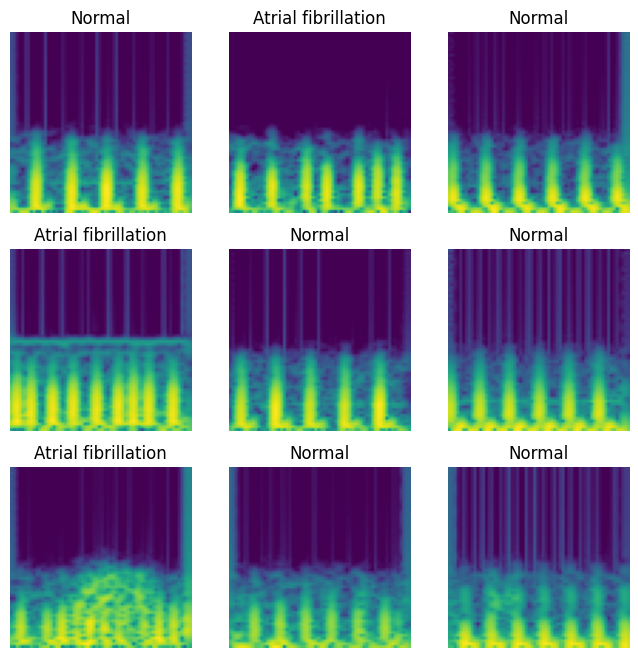

In [2]:
labels_map = {
    0: "Normal",
    1: "Atrial fibrillation"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [3]:
from torchsummary import summary
from Network.afib_detector_v0_1 import AfibDetector

net = AfibDetector()

if torch.cuda.is_available():
    net.cuda()

summary(net, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]             416
              ReLU-2           [-1, 16, 60, 60]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10                 [-1, 2304]               0
           Linear-11                   [-1, 64]         147,520
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
          Softmax-14                   

In [4]:
import torch.nn as nn
from torch import optim
from Utils.model_trainer import ModelTrainer

learning_rate = 0.005
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

#TODO
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.003)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print("Device:", device)

modelTrainer = ModelTrainer()

modelTrainer.train_model(
    net,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    device,
    5
)

#TODO
# ModelTrainer.save_checkpoint(net.epoch, net, optimizer, "./Models/afib_detector_v0_1_checkpoint.pt")

# checkpoint = torch.load(CHECKPOINT_PATH)
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']
# print(f"Resuming training from epoch {start_epoch}")

Device: cuda:0
EPOCH 1:
	batch 336 loss: 0.6931119192214239
	batch 672 loss: 0.6925510806696755
	batch 1008 loss: 0.6913096628018788
	batch 1344 loss: 0.6747876322340398
	batch 1680 loss: 0.5749968632700897
LOSS train 0.5749968632700897 valid 0.6576516540486569 ACCURACY 0.6063129305839539
EPOCH 2:
	batch 336 loss: 0.5235892123587075
	batch 672 loss: 0.4902045459796985
	batch 1008 loss: 0.4754422841859715
	batch 1344 loss: 0.46467522185828003
	batch 1680 loss: 0.4536518268287182
LOSS train 0.4536518268287182 valid 0.4370537953818496 ACCURACY 0.8759341239929199
EPOCH 3:
	batch 336 loss: 0.4463816792482421
	batch 672 loss: 0.4388768234778018
	batch 1008 loss: 0.4331858585632983
	batch 1344 loss: 0.4297674567039524
	batch 1680 loss: 0.43169296763482545
LOSS train 0.43169296763482545 valid 0.41594944444801346 ACCURACY 0.8967170715332031
EPOCH 4:
	batch 336 loss: 0.43098642073926474
	batch 672 loss: 0.4235812374168918
	batch 1008 loss: 0.4192796439109814
	batch 1344 loss: 0.4176438215765215


In [5]:
MODEL_PATH = "./Models/afib_detector_v0_1_3.pt"
torch.save(net.state_dict(), MODEL_PATH)